# O3 Air Pollution Predictive Modelling.

Imports

In [2]:
#data frame
import pandas as pd
import numpy as np

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# machine laerning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer


## Time series analysis

Reading in data

In [3]:
# Loading the dataset
df = pd.read_csv('India_complete.csv', low_memory=False)

# Parse datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract useful time features
df['hour'] = df['datetime'].dt.hour
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['dayofweek'] = df['datetime'].dt.dayofweek

# Displaying the first few rows of the dataframe
print(df.head())

             datetime StationId                     StationName       City  \
0 2017-11-24 17:00:00     AP001  Secretariat, Amaravati - APPCB  Amaravati   
1 2017-11-24 18:00:00     AP001  Secretariat, Amaravati - APPCB  Amaravati   
2 2017-11-24 19:00:00     AP001  Secretariat, Amaravati - APPCB  Amaravati   
3 2017-11-24 20:00:00     AP001  Secretariat, Amaravati - APPCB  Amaravati   
4 2017-11-24 21:00:00     AP001  Secretariat, Amaravati - APPCB  Amaravati   

            State        lat        lon  Status  PM2.5    PM10  ...    NH3  \
0  Andhra Pradesh  16.494222  80.510586  Active  60.50   98.00  ...   8.50   
1  Andhra Pradesh  16.494222  80.510586  Active  65.50  111.25  ...   9.77   
2  Andhra Pradesh  16.494222  80.510586  Active  80.00  132.00  ...  12.02   
3  Andhra Pradesh  16.494222  80.510586  Active  81.50  133.25  ...  11.58   
4  Andhra Pradesh  16.494222  80.510586  Active  75.25  116.00  ...  12.03   

    CO    SO2      O3  AQI  AQI_Bucket  hour  month day  dayof

Descriptive Stats

In [8]:
# Summary statistics for numeric variables
def summary_stats(df):

    # print nimber of stations
    print(f"Number of unique stations: {df['StationId'].nunique()}")
    
    print("Descriptive Statistics:")
    df_desc = df.drop(['hour', 'month', 'dayofweek', 'datetime', 'lat', 'lon', 'day'], axis=1)
    print(df_desc.describe())

    print("Missing Values:")
    print(df.isnull().sum())


summary_stats(df)

Number of unique stations: 110
Descriptive Statistics:
              PM2.5          PM10            NO           NO2           NOx  \
count  1.941394e+06  1.469831e+06  2.035372e+06  2.060110e+06  2.098275e+06   
mean   8.086481e+01  1.584839e+02  2.278825e+01  3.523689e+01  4.055115e+01   
std    8.947618e+01  1.397883e+02  4.846146e+01  3.497508e+01  5.590894e+01   
min    1.000000e-02  1.000000e-02  1.000000e-02  1.000000e-02  0.000000e+00   
25%    2.816000e+01  6.400000e+01  3.050000e+00  1.310000e+01  1.135000e+01   
50%    5.259000e+01  1.162500e+02  7.150000e+00  2.479000e+01  2.286000e+01   
75%    9.774000e+01  2.040000e+02  1.858000e+01  4.548000e+01  4.570000e+01   
max    1.000000e+03  1.000000e+03  5.000000e+02  4.999900e+02  5.000000e+02   

                NH3            CO           SO2            O3           AQI  
count  1.352465e+06  2.089781e+06  1.846346e+06  1.863110e+06  2.018893e+06  
mean   2.870856e+01  1.502366e+00  1.211602e+01  3.806408e+01  1.801730e+02  

In [15]:
def o3_stats(df):
    # Print O3 statistics
    print(f"\nO3 Statistics:")
    print(f"Mean O3: {df['O3'].mean():.2f}")
    print(f"Median O3: {df['O3'].median():.2f}")
    print(f"Min O3: {df['O3'].min():.2f}")
    print(f"Max O3: {df['O3'].max():.2f}")

o3_stats(df)


O3 Statistics:
Mean O3: 38.06
Median O3: 24.75
Min O3: 0.01
Max O3: 997.00


Map visualsation

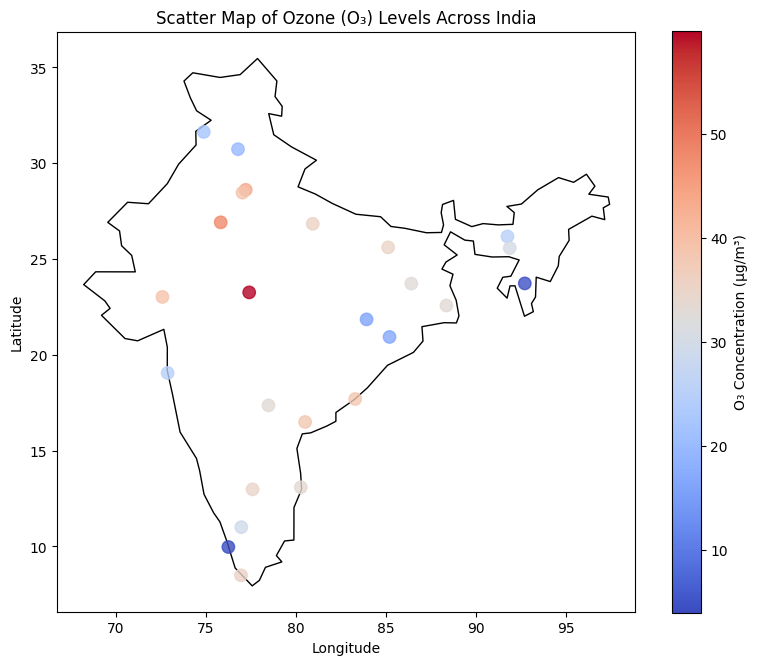

In [101]:
def map_vis(df):

    # Load Natural Earth countries (1:110m resolution)
    url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
    world = gpd.read_file(url)

    # Filter for India
    india = world[world["ADMIN"] == "India"]


    # grouping by city as hard to see individual points otherwise

    # groups by city and takes mean of O3 values
    df_mean = df.groupby(['City']).mean('O3').reset_index()
    # Remove rows with NaN values in or 'O3' columns
    df_clean = df_mean.dropna(subset=["O3"])

    gdf = gpd.GeoDataFrame(
        df_clean,  # remove NaNs
        geometry=gpd.points_from_xy(df_clean["lon"], df_clean["lat"]),
        crs="EPSG:4326"
    )

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(8, 10))
    india.plot(ax=ax, color="white", edgecolor="black")  # India boundary

    # Scatter plot of O3 levels
    gdf.plot(
        ax=ax,
        column="O3",        # pollutant column
        cmap="coolwarm",        # color scheme
        markersize=80,      # adjust dot size
        alpha=0.8,
        legend=True,
        legend_kwds={
        "label": "O₃ Concentration (µg/m³)",   # ← your legend label
        "shrink": 0.6                         # optional: smaller colorbar
    }
    )

    plt.title("Scatter Map of Ozone (O₃) Levels Across India")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    plt.show()

map_vis(df)

Visualising time series.

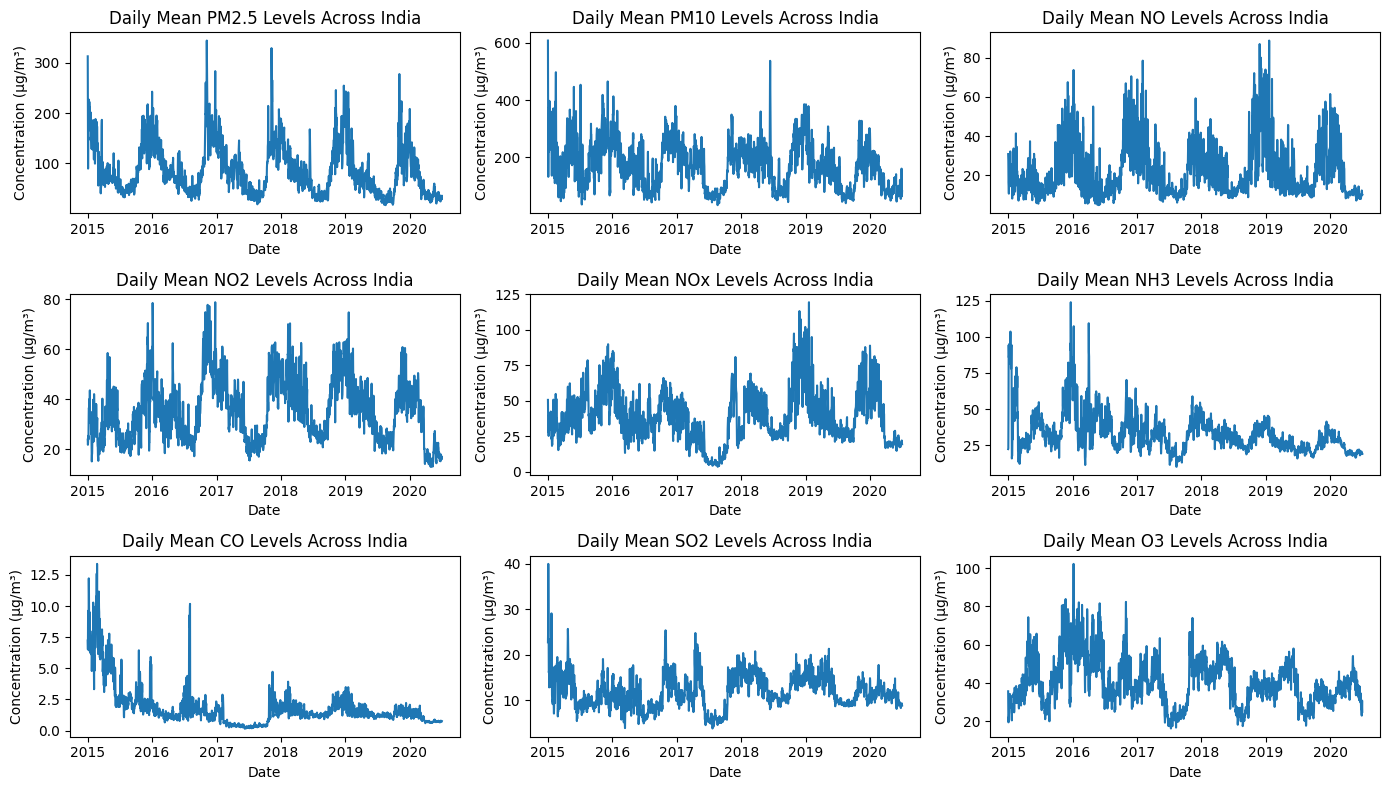

In [23]:
def ozone_time_series(df):
    
    # group by day (drop the time component)
    df_mean = (
        df.groupby(df['datetime'].dt.date)['O3']
        .mean()
        .reset_index()
    )

    # rename for clarity
    df_mean.columns = ['date', 'O3']

    # plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_mean, x='date', y='O3')
    plt.title('Daily Mean Ozone (O₃) Levels Across India')
    plt.xlabel('Date')
    plt.ylabel('O₃ Concentration (µg/m³)')
    plt.tight_layout()
    plt.show()


def all_pollutatants_time_series(df):

    pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']

    monthly_mean = (
    df.groupby(pd.Grouper(key='datetime', freq='D'))[pollutants]
      .mean()
      .reset_index()
    )

    # plot on different graphs for clarity

    plt.figure(figsize=(14, 8))
    for i, pollutant in enumerate(pollutants, 1):
        plt.subplot(3, 3, i)
        sns.lineplot(data=monthly_mean, x='datetime', y=pollutant)
        plt.title(f'Daily Mean {pollutant} Levels Across India')
        plt.xlabel('Date')
        plt.ylabel('Concentration (µg/m³)')
        plt.tight_layout()
    plt.show()
    

#ozone_time_series(df)
all_pollutatants_time_series(df)

Random station ozone time series

In [ ]:

def random_station_ozone_time_series(df):

    # select a random city
    random_station = df['StationId'].sample(n=1).values[0]

    df_station = df[df['StationId'] == random_station]

    # group by day (drop the time component)
    df_mean = (
        df_station.groupby(df_station['datetime'].dt.date)['O3']
        .mean()
        .reset_index()
    )

    # rename for clarity
    df_mean.columns = ['date', 'O3']

    # plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_mean, x='date', y='O3')
    plt.title(f'Daily Mean Ozone (O₃) Levels in {df_station["City"].values[0]} (Station {random_station}) ')
    plt.xlabel('Date')
    plt.ylabel('O₃ Concentration (µg/m³)')
    plt.tight_layout()
    plt.show()

random_station_ozone_time_series(df)

Seasonal Trends

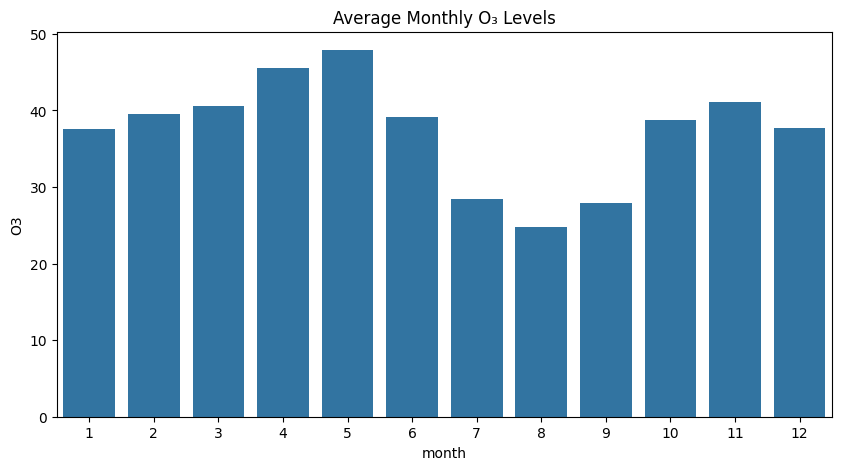

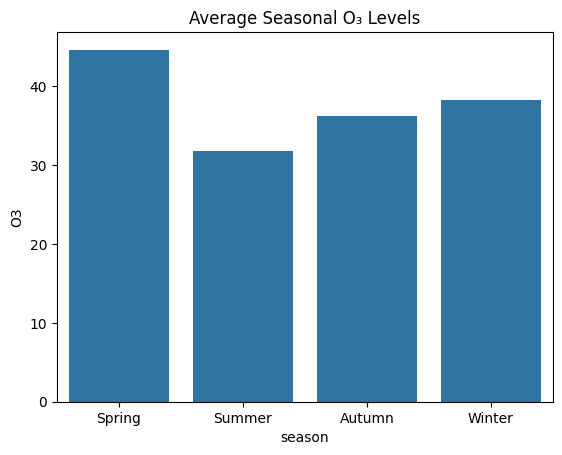

In [108]:
def seasonal_trends(df):

    
    df['weekday_name'] = df['datetime'].dt.day_name()

    # Visualization
    plt.figure(figsize=(10,5))
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Autumn'

    df['season'] = df['month'].apply(get_season)

    monthly_summary = df.groupby('month')['O3'].mean().reset_index()
    sns.barplot(x='month', y='O3', data=monthly_summary)
    plt.title('Average Monthly O₃ Levels')
    plt.show()

    seasonal_summary = df.groupby('season')['O3'].mean().reset_index()
    sns.barplot(x='season', y='O3', data=seasonal_summary, order=['Spring', 'Summer', 'Autumn', 'Winter'])
    plt.title('Average Seasonal O₃ Levels')
    plt.show()

seasonal_trends(df)

Histograms

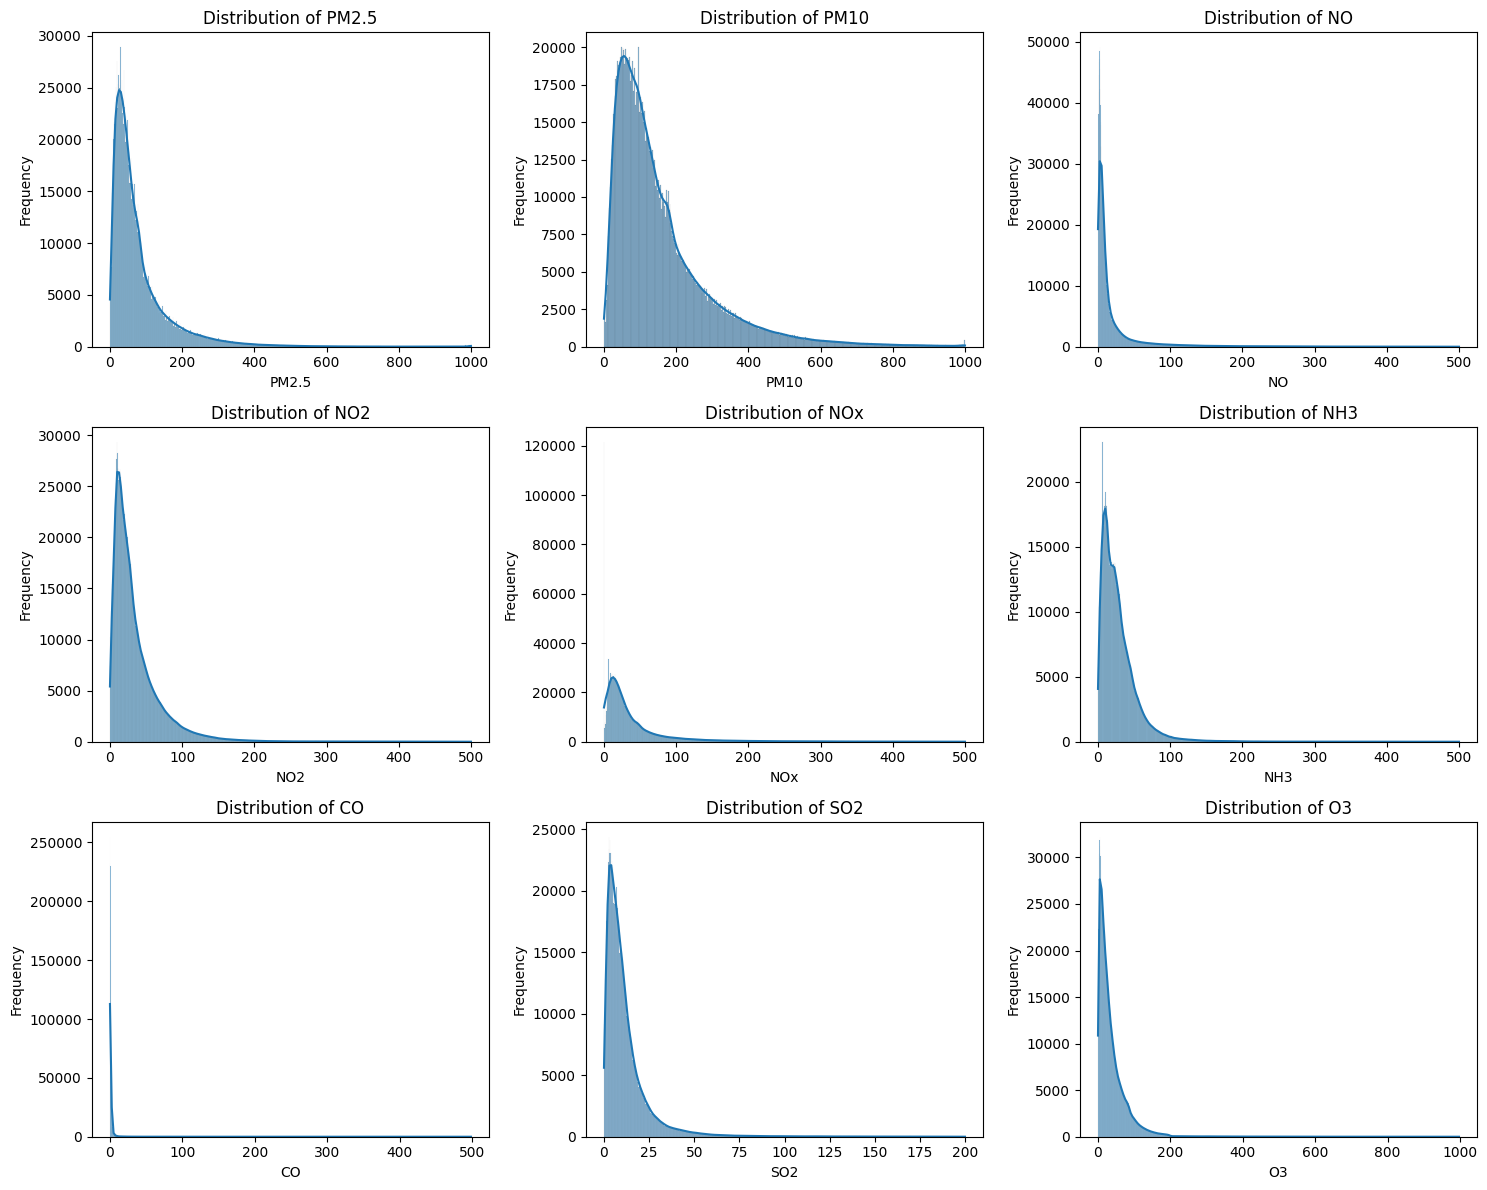

In [ ]:
def histograms(df):
    numeric_features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']

    # Create subplots for all histograms
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()  # Make indexing easier

    for i, col in enumerate(numeric_features):
        sns.histplot(df[col], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].axvline(df[col].mean(), color='r', linestyle='--', label='Mean'),
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')


    plt.tight_layout()
    plt.show()


histograms(df)

Correlation matrix


Correlation with O3:
AQI          0.132111
hour         0.103756
SO2          0.098339
NH3          0.084150
lat          0.083183
NO2          0.060923
PM2.5        0.057122
PM10         0.002009
dayofweek   -0.001492
day         -0.007836
Name: O3, dtype: float64


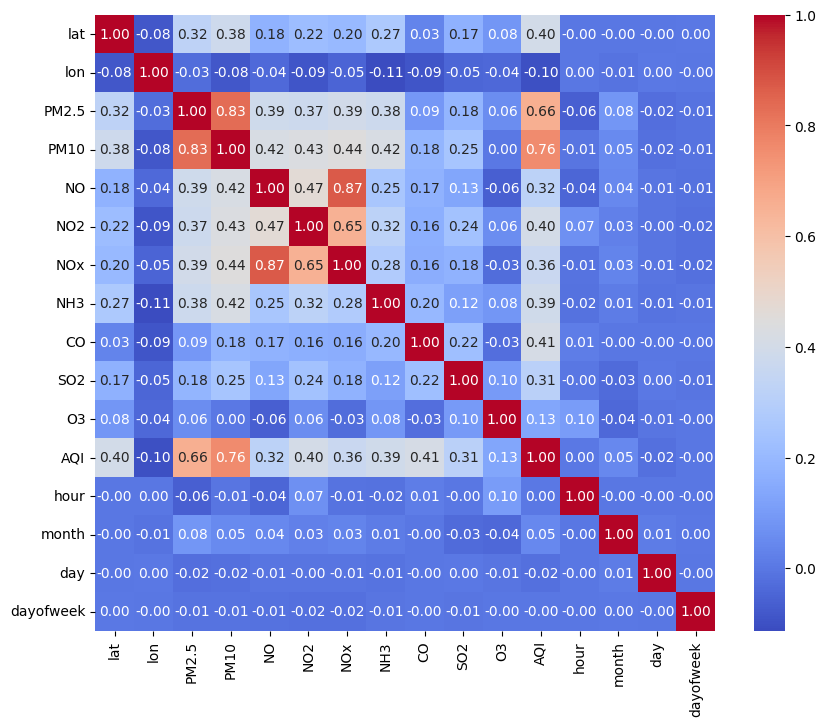

In [18]:
def correlation_matrix(df):

    # Correlation matrix for pollutants.
    df_corr = df.drop(['AQI_Bucket', 'City', 'datetime', 'StationId', 'StationName', 'Status', 'State'], axis=1)
    corr_matrix = df_corr.corr()

    # Show strong correlations with 03
    if 'O3' in corr_matrix.columns:
        O3_corr = corr_matrix['O3'].sort_values(ascending=False)
        print("\nCorrelation with O3:")
        print(O3_corr[1:11])

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')

correlation_matrix(df)

Covariance Matrix

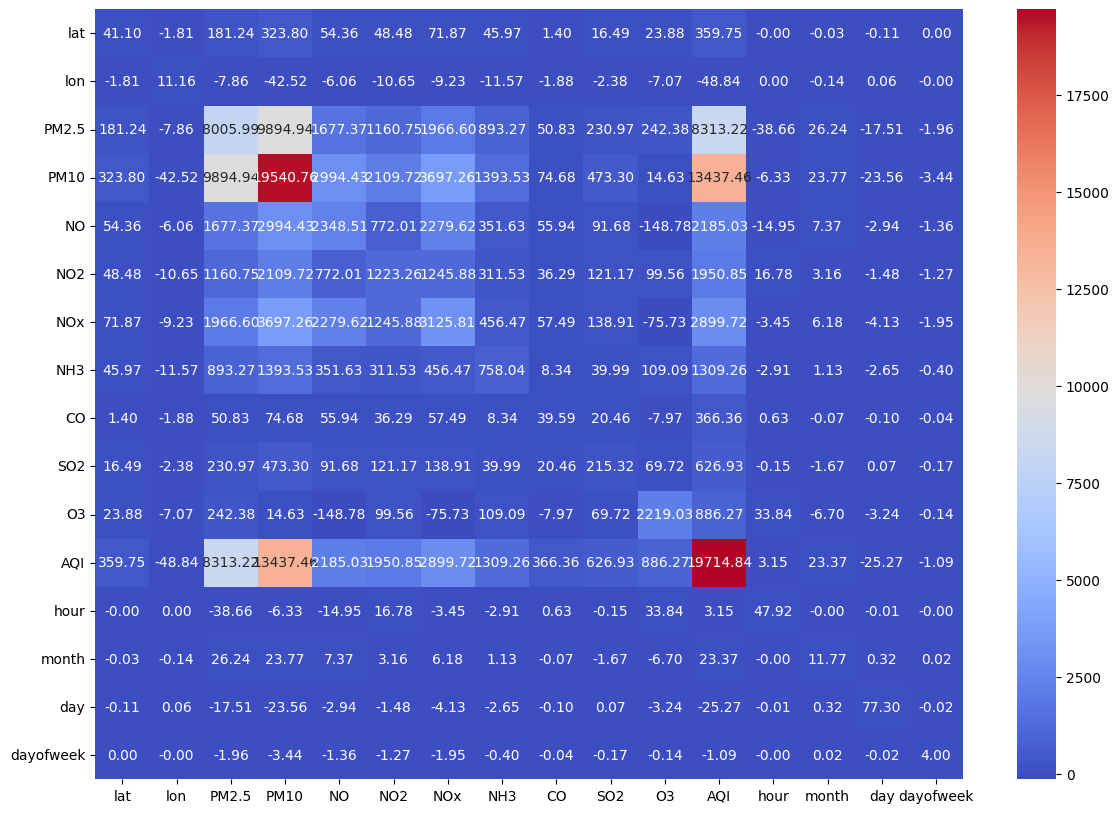

In [106]:
def cov_matrix(df):

    # Correlation matrix for pollutants.
    df_cov = df.drop(['AQI_Bucket', 'City', 'datetime', 'StationId', 'StationName', 'Status', 'State'], axis=1)
    cov_matrix = df_cov.cov()

    plt.figure(figsize=(14, 10))
    sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap='coolwarm')

cov_matrix(df)

Distribution of AQI

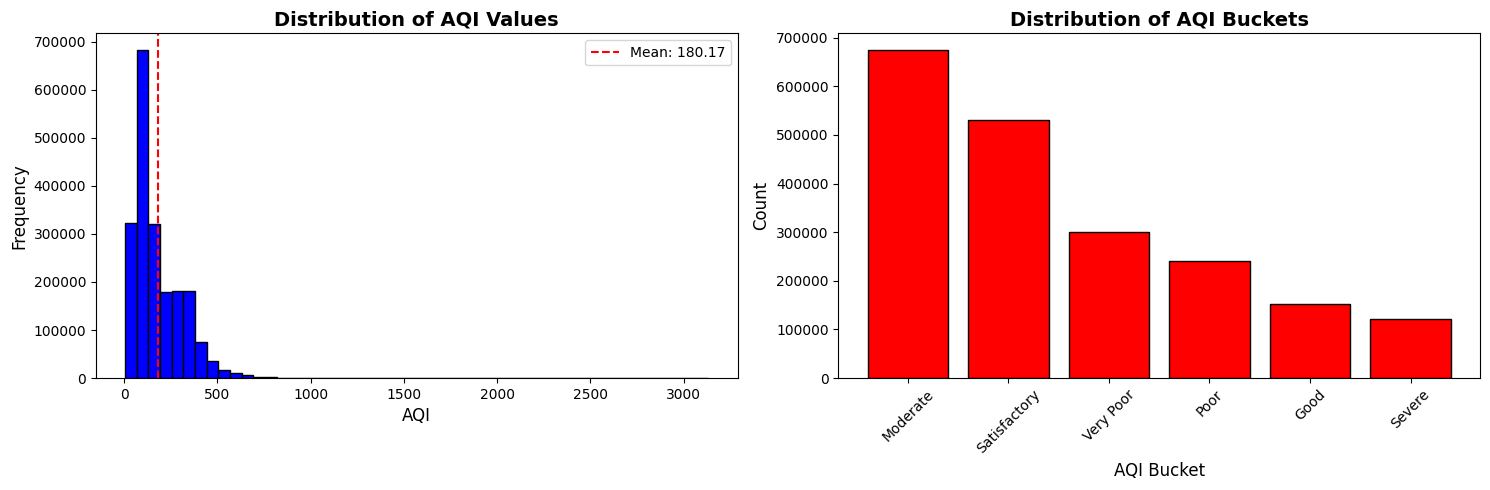

In [ ]:
def aqi_plots(df):
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # 03 distribution
    axes[0].hist(df['AQI'].dropna(), bins=50, color='blue', edgecolor='black')
    axes[0].set_title('Distribution of AQI Values', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('AQI', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].axvline(df['AQI'].mean(), color='red', linestyle='--', label=f'Mean: {df["AQI"].mean():.2f}')
    axes[0].legend()

    # # AQI Bucket distribution
    aqi_bucket_counts = df['AQI_Bucket'].value_counts()
    axes[1].bar(aqi_bucket_counts.index, aqi_bucket_counts.values, color='red', edgecolor='black')
    axes[1].set_title('Distribution of AQI Buckets', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('AQI Bucket', fontsize=12)
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

aqi_plots(df)

Yearly trends

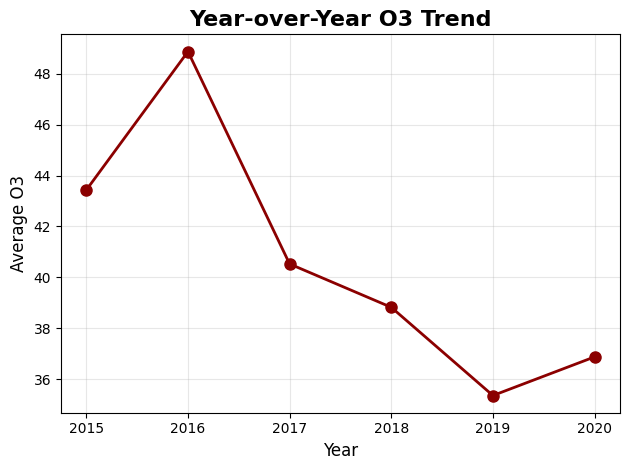

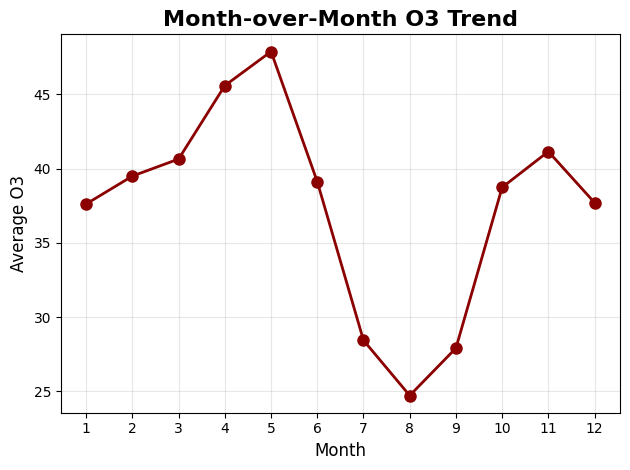

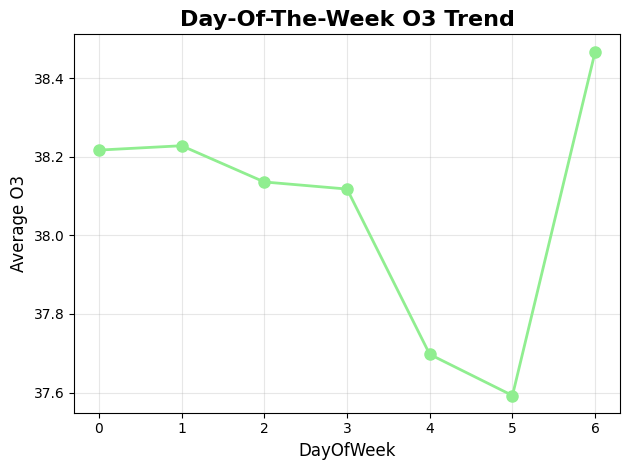

In [67]:
def yearly_fig(df):

    df['Year'] = df['datetime'].dt.year
    # # Year-over-Year O3 Trend
    yearly_O3 = df.groupby('Year')['O3'].mean().reset_index()

    #print("\nYearly O3 Summary:")
    #print(yearly_O3)

    #plt.figure(figsize=(8, 6))
    plt.plot(yearly_O3['Year'], yearly_O3['O3'], marker='o', linewidth=2, 
             markersize=8, color='darkred')
    plt.title('Year-over-Year O3 Trend', fontsize=16, fontweight='bold')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Average O3', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(yearly_O3['Year'])
    plt.tight_layout()
    plt.show()

def monthly_fig(df):
    # Month-over-Month O3 Trend
    monthly_O3 = df.groupby('month')['O3'].mean().reset_index()

    #print("\nMonthly O3 Summary:")
    #print(monthly_O3)

    #plt.figure(figsize=(8, 6))
    plt.plot(monthly_O3['month'], monthly_O3['O3'], marker='o', linewidth=2, 
            markersize=8, color='darkred')
    plt.title('Month-over-Month O3 Trend', fontsize=16, fontweight='bold')
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Average O3', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(monthly_O3['month'])
    plt.tight_layout()
    plt.show()

def day_of_week_fig(df):
    # Day of the week O3 Trend
    day_of_week_O3 = df.groupby('dayofweek')['O3'].mean().reset_index()

    #print("\nDaily O3 Summary:")
    #print(day_of_week_O3)

    #plt.figure(figsize=(8, 6))
    plt.plot(day_of_week_O3['dayofweek'], day_of_week_O3['O3'], marker='o', linewidth=2, 
            markersize=8, color='lightgreen')
    plt.title('Day-Of-The-Week O3 Trend', fontsize=16, fontweight='bold')
    plt.xlabel('DayOfWeek', fontsize=12)
    plt.ylabel('Average O3', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(day_of_week_O3['dayofweek'])
    plt.tight_layout()
    plt.show()

yearly_fig(df)
monthly_fig(df)
day_of_week_fig(df)

Top 50 Worst days for O3 pollution all in same place.

In [46]:
def top_O3_days(df):
    df['Year'] = df['datetime'].dt.year
    # Get top 50 days with Highest O3
    top_O3_days = df.nlargest(50, 'O3')[['datetime', 'StationName','O3']]

    print("=" * 50)
    print("Top 50 days with Highest O3")
    print("=" * 50)
    print(top_O3_days.to_string(index=False))

top_O3_days(df)

Top 50 days with Highest O3
           datetime                StationName     O3
2019-11-03 14:00:00 Punjabi Bagh, Delhi - DPCC 997.00
2018-06-13 05:00:00 Punjabi Bagh, Delhi - DPCC 996.00
2019-11-03 07:00:00 Punjabi Bagh, Delhi - DPCC 996.00
2019-01-20 00:00:00 Punjabi Bagh, Delhi - DPCC 992.00
2017-11-08 07:00:00 Punjabi Bagh, Delhi - DPCC 989.00
2016-01-04 22:00:00 Punjabi Bagh, Delhi - DPCC 988.17
2015-11-20 12:00:00 Punjabi Bagh, Delhi - DPCC 984.33
2016-01-07 09:00:00 Punjabi Bagh, Delhi - DPCC 982.00
2019-11-03 08:00:00 Punjabi Bagh, Delhi - DPCC 982.00
2017-11-08 09:00:00 Punjabi Bagh, Delhi - DPCC 980.00
2017-11-09 09:00:00 Punjabi Bagh, Delhi - DPCC 977.00
2020-01-01 23:00:00 Punjabi Bagh, Delhi - DPCC 975.00
2016-11-02 09:00:00 Punjabi Bagh, Delhi - DPCC 974.50
2017-11-12 09:00:00 Punjabi Bagh, Delhi - DPCC 974.00
2018-06-12 15:00:00 Punjabi Bagh, Delhi - DPCC 974.00
2017-11-10 10:00:00 Punjabi Bagh, Delhi - DPCC 973.00
2017-12-11 03:00:00 Punjabi Bagh, Delhi - DPCC 973.00


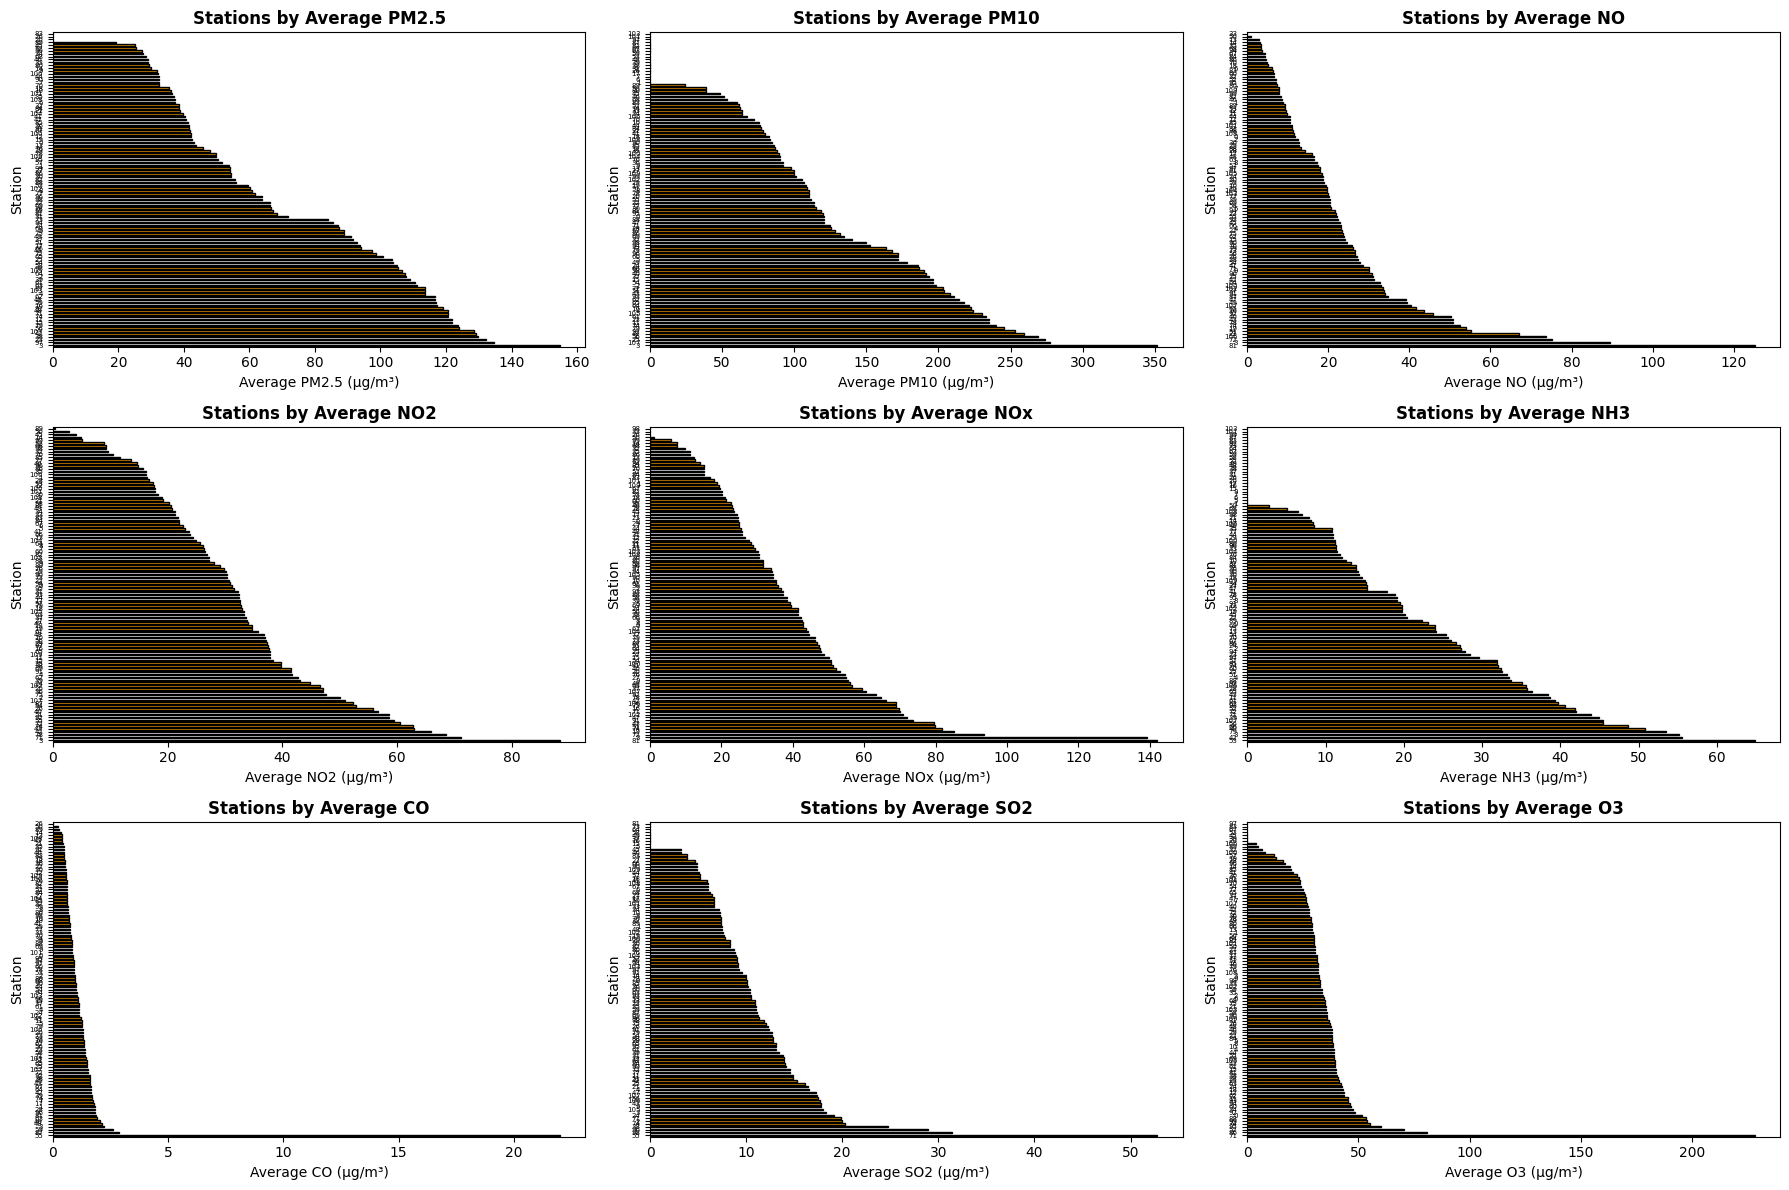

In [63]:
def avg_pollutant_by_station(df):

    # pollutant list
    pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']

    stations_mean = (
        df.groupby('StationName')[pollutants]
          .mean()
          .reset_index()
    )

    # Stations by average pollutant levels

    # Create subplots: 3 rows × 3 columns
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    axes = axes.flatten()  # make axes 1D for easy looping

    # Plot each pollutant
    for i, pollutant in enumerate(pollutants):
        # Sort stations for that pollutant
        sorted_data = stations_mean[pollutant].sort_values(ascending=False)

        sorted_data.plot(
            kind='barh',
            ax=axes[i],
            color='orange',
            edgecolor='black'
        )
        axes[i].set_title(f'Stations by Average {pollutant}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(f'Average {pollutant} (µg/m³)', fontsize=10)
        axes[i].set_ylabel('Station', fontsize=10)
        axes[i].tick_params(axis='y', labelsize=5)


    plt.tight_layout()
    plt.show()

avg_pollutant_by_station(df)

Nan value analysis.

In [107]:
# Check missing values
print(df.isnull().sum())

datetime             0
StationId            0
StationName          0
City                 0
State                0
lat                  0
lon                  0
Status            7706
PM2.5           647689
PM10           1119252
NO              553711
NO2             528973
NOx             490808
NH3            1236618
CO              499302
SO2             742737
O3              725973
AQI             570190
AQI_Bucket      570190
hour                 0
month                0
day                  0
dayofweek            0
dtype: int64


Outliers.

imputing for nan values

## Modelling

data set prep and splitting

In [109]:
# Remove rows where target variable (O3) is missing
df_clean = df.dropna(subset=['O3'])

# Prepare features and target - EXCLUDE O3 from features since it's our target
feature_columns = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'hour', 'month', 'dayofweek']
X = df_clean[feature_columns]  # Can contain NaN values
y = df_clean['O3']  # Should not contain NaN

# Split into train-test FIRST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


random forest

In [ ]:
def random_forest_grid_search(X_train, X_test, y_train, y_test):

    param_grid = {
    'max_features': [0.6, 0.8, 1, 'sqrt', 'log2'],
    'max_samples': [0.6, 0.8, 1],
    'max_depth': [10, 20, None]

    }

    grid = HalvingGridSearchCV(
        estimator=RandomForestRegressor(n_estimators=100, random_state=1),
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        return_train_score=True,
        verbose =2
    )

    grid.fit(X_train, y_train)

    print("Best Parameters:", grid.best_params_)
    print("Best Score:", -grid.best_score_)

    return grid.best_estimator_

def random_forest(X_train, X_test, y_train, y_test, best_params = None):

    # Then create and fit model ONLY on training data
    if best_params:
        regr = RandomForestRegressor(
            n_estimators=100,
            random_state=42,
            max_features=best_params['max_features'],
            max_samples=best_params['max_samples'],
            max_depth=best_params['max_depth']
        )
    else:
        regr = RandomForestRegressor(
            n_estimators=100,
            random_state=42
        )

    regr.fit(X_train, y_train)

    # Predictions
    y_train_pred = regr.predict(X_train)
    y_test_pred = regr.predict(X_test)

    # Evaluation
    def evaluate(y_true, y_pred, dataset_type="Test"):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        print(f"{dataset_type} MAE: {mae:.2f}")
        print(f"{dataset_type} MSE: {mse:.2f}")
        print(f"{dataset_type} RMSE: {rmse:.2f}")
        print(f"{dataset_type} R²: {r2:.2f}")

    evaluate(y_train, y_train_pred, "Train")
    evaluate(y_test, y_test_pred, "Test")

    def plotting():

        # Feature Importance
        importances = regr.feature_importances_
        feature_names = X_train.columns
        feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
        # plot feature importances
        plt.figure(figsize=(10, 6))
        sns.barplot(x=feature_importances, y=feature_importances.index)
        plt.title('Feature Importances from Random Forest')
        plt.xlabel('Importance Score')
        plt.ylabel('Features')
        plt.tight_layout()
        plt.show()

        # Residual Analysis
        residuals = y_test - y_test_pred
        plt.figure(figsize=(10, 5))
        sns.histplot(residuals, kde=True)
        plt.title('Residual Distribution')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

        # plotting tree
        tree_to_plot = regr.estimators_[0]

        plt.figure(figsize=(20, 10))
        plot_tree(tree_to_plot, max_depth = 3, feature_names=df.columns.tolist(), filled=True, rounded=True, fontsize=10)
        plt.title("Decision Tree from Random Forest")
        plt.show()

    plotting()

    return regr

random_forest_model = random_forest(X_train, X_test, y_train, y_test)



xgboost

R²: 0.567
RMSE: 31.360
MAE: 20.015
Cross-Validation Mean R²: 0.162 ± 0.068

Permutation Feature Importances:
PM10         0.663731
PM2.5        0.462548
hour         0.178862
NH3          0.161387
NO2          0.128952
NO           0.108325
NOx          0.047707
month        0.045139
SO2          0.042191
CO           0.011088
dayofweek    0.000030
dtype: float64


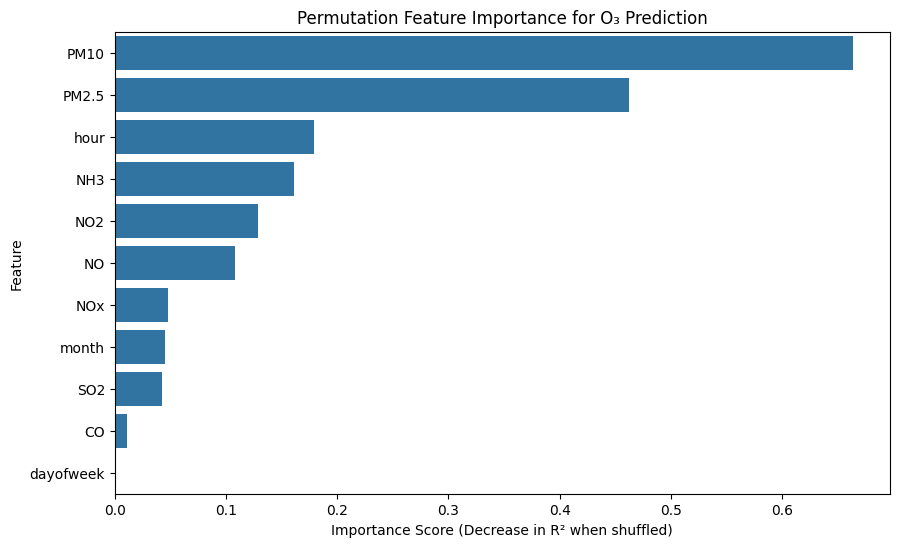

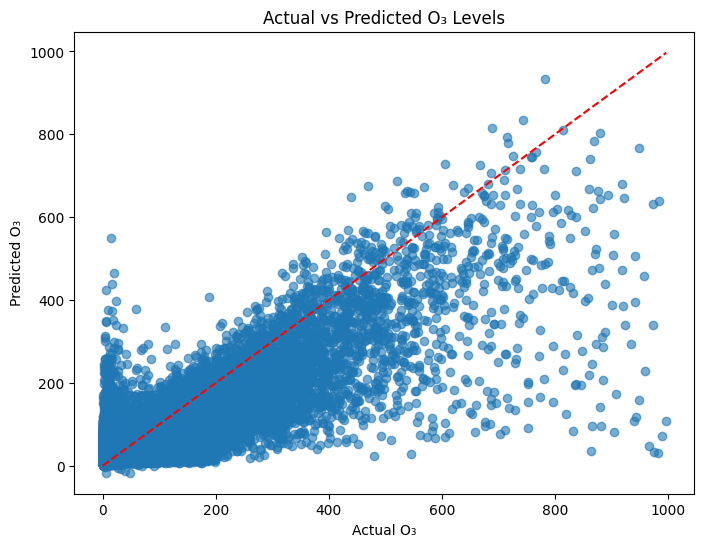

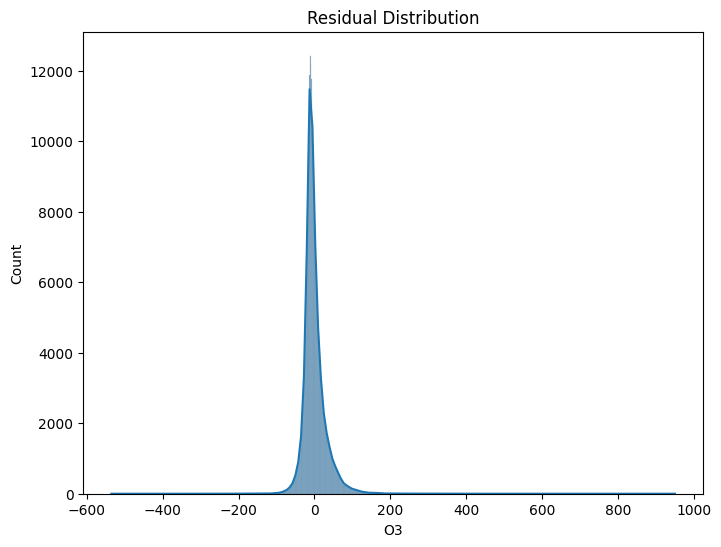

In [112]:
def xg_boost(X_train, X_test, y_train, y_test):

    # Then create and fit model ONLY on training data
    model = HistGradientBoostingRegressor(
        random_state=42,
        max_iter=100  # equivalent to n_estimators in RF
    )

    # Fit directly with NaN values
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f'R²: {r2:.3f}')
    print(f'RMSE: {rmse:.3f}')
    print(f'MAE: {mae:.3f}')

    # Cross-validation - create fresh model for CV
    cv_model = HistGradientBoostingRegressor(random_state=42, max_iter=100)
    cv_scores = cross_val_score(cv_model, X, y, cv=5, scoring='r2')
    print(f'Cross-Validation Mean R²: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}')

    # Use permutation importance
    from sklearn.inspection import permutation_importance

    # Calculate permutation importance on test set
    perm_importance = permutation_importance(model, X_test, y_test, random_state=42, n_repeats=10)
    importances = pd.Series(perm_importance.importances_mean, index=X.columns).sort_values(ascending=False)

    print("\nPermutation Feature Importances:")
    print(importances)

    plt.figure(figsize=(10,6))
    sns.barplot(x=importances.values, y=importances.index)
    plt.title('Permutation Feature Importance for O₃ Prediction')
    plt.xlabel('Importance Score (Decrease in R² when shuffled)')
    plt.ylabel('Feature')
    plt.show()

    plt.figure(figsize=(8,6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.xlabel("Actual O₃")
    plt.ylabel("Predicted O₃")
    plt.title("Actual vs Predicted O₃ Levels")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect fit line
    plt.show()

    # Residual plot
    residuals = y_test - y_pred
    plt.figure(figsize=(8,6))
    sns.histplot(residuals, kde=True)
    plt.title('Residual Distribution')
    plt.show()

    # return results or model

xg_boost(X_train, X_test, y_train, y_test)

svm

knn

Neural Net/ lstm 

### comparing results